In [86]:
%matplotlib inline

In [136]:
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, spm   
from nipype.interfaces.base import Bunch
import nipype.interfaces.spm as spm
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting
from nilearn import image
from nilearn.image import mean_img
from nilearn.image import threshold_img
from nilearn import plotting
from nilearn.regions import connected_regions
from nilearn.regions import RegionExtractor
from nilearn.image import concat_imgs, index_img
from nilearn.plotting import find_xyz_cut_coords
from numpy import asarray
import matplotlib.pyplot as plt
import pandas as pd


# Only run this section once!

In [33]:
#this is because I forgot named the files .nii instead of .nii.gz.
#If this isn't done then we get the following error below: nilearn ImageFileError: Cannot work out file type of *
!find /home/jovyan/ClassData/LabResults/ -type f -name "*.nii" -exec mv {} {}.nii.gz \;


In [ ]:
# All of your .nii files should end in .gz now

In [39]:
!find /home/jovyan/ClassData/LabResults/ -type f -name '*.nii*'

/home/jovyan/ClassData/LabResults/sid001551_2_School vs. others.nii
/home/jovyan/ClassData/LabResults/sid001561_3_Social.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001560_1_Event.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001550_1_Career.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001548_3_Social.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001560_3_Event.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001562_3_Social.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001550_1_Event.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001562_3_Career.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001548_2_Career.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid000118_2_School vs. others.nii
/home/jovyan/ClassData/LabResults/sid001562_1_School.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001548_1_Event.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid001561_2_Event.nii.gz.nii.gz
/home/jovyan/ClassData/LabResults/sid000747_1_Event.nii.gz.nii.gz

# Select the files you want to analyze
Change the text below select files to run an analysis on. The code below only selects Social images for run 1. You will need to change this for your particular analysis question.

In [45]:
img=nilearn.image.load_img(glob.glob('/home/jovyan/ClassData/LabResults/*_1_Social.nii.gz'))

#This line would select all social images
#statimg=nilearn.image.new_img_like(glob.glob('/home/jovyan/ClassData/LabResults/*_Social.nii.gz.nii.gz')[0], tstat, affine=None, copy_header=False)



# This tells us the shape of the file in the first 3 dimensions then the 4th is the number of subjects we have.

In [46]:
img.shape

(97, 115, 97, 9)

# Load the data you selected into memory

In [76]:
data = img.get_fdata()

In [1]:
!pip install scipy

In [90]:
tstat,pval=scipy.stats.ttest_1samp(data,0,axis=3) #this performs the t-test along the 4th axis, which is the subjects axis
statimg=nilearn.image.new_img_like(glob.glob('/home/jovyan/ClassData/LabResults/*_1_Social.nii.gz.nii.gz')[0], tstat, affine=None, copy_header=False)
pvalimg=nilearn.image.new_img_like(glob.glob('/home/jovyan/ClassData/LabResults/*_1_Social.nii.gz.nii.gz')[0], pval, affine=None, copy_header=False)

In [91]:
# This should be the same size as the first 3 number in the shape example above
tstat.shape

(97, 115, 97)

# Save our stat map into a new directory
You will need to change the filenames and/or directories that these are saved into if you are running this on multiple categories

In [92]:
!mkdir /home/jovyan/ClassData/LabResults/Results
statimg.to_filename('/home/jovyan/ClassData/LabResults/Results/Social_tmap.nii.gz')
statimg.to_filename('/home/jovyan/ClassData/LabResults/Results/Social_pval.nii.gz')


In [84]:
statimg.shape

(97, 115, 97)

# Plot an unthresholded t-stat map

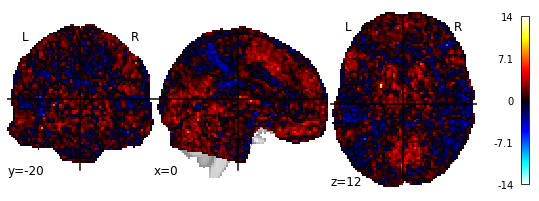

In [87]:
plotting.plot_stat_map(statimg)

# Plot a thresholded t-tstat map

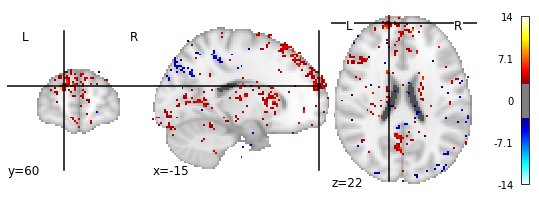

In [94]:
plotting.plot_stat_map(statimg, threshold=3)


# Plotting non-volume corrected results
If you still get no contour levels were found then you can plot non-volume corrected values but that must be mentioned in the results. A table of p to t values is here, the t-value should be entered as the threshold below. This can be approxmated with p<0.001 usually equates to t~3.9, p<0.05 equates to t~2.1.

Resources:
https://faculty.washington.edu/heagerty/Books/Biostatistics/TABLES/t-Tables/
https://www.khanacademy.org/math/ap-statistics/tests-significance-ap/one-sample-t-test-mean/v/calculating-p-value-from-t-statistic

More options for displaying your results:
http://nilearn.github.io/auto_examples/01_plotting/plot_demo_plotting.html

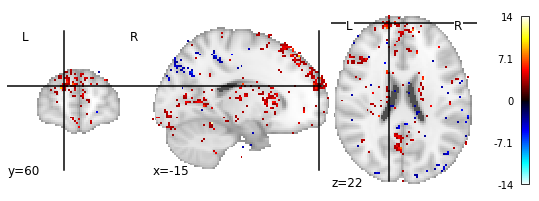

In [101]:
threshold_value_img = threshold_img(statimg, threshold=3.0)
plotting.plot_stat_map(threshold_value_img)


/opt/conda/lib/python3.7/site-packages/nilearn/plotting/displays.py:98: UserWarning: No contour levels were found within the data range.
  **kwargs)


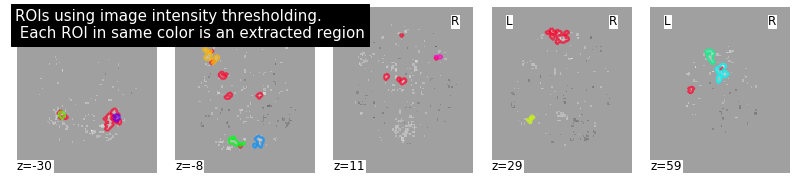

In [100]:
#This identifies clusters of significant voxels as defined above
#min region size here is somewhat arbitrary but set so we don't pick up just a couple proximal voxels
regions_value_img, index = connected_regions(threshold_value_img,
                                             min_region_size=50)

In [127]:
# min_region_size arbitrarily set to 50 here, can be higher or lower
# Import Region Extractor algorithm from regions module
# threshold is the t value you want to threshold on
# maps, less the threshold means that more intense non-voxels will be survived.
threshold=3
min_region_size=50*2.5*2.5*2.5 #50 voxels x the shape of each voxel
extractor = RegionExtractor(regions_value_img, threshold=threshold,
                            thresholding_strategy='img_value',#'ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=min_region_size)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]
#display how many regions were extracted with our parameters
n_regions_extracted


6

/opt/conda/lib/python3.7/site-packages/nilearn/plotting/displays.py:98: UserWarning: No contour levels were found within the data range.
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/ma/core.py:2786: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/opt/conda/lib/python3.7/site-packages/nilearn/plotting/displays.py:98: UserWarning: linewidths is ignored by contourf
  **kwargs)


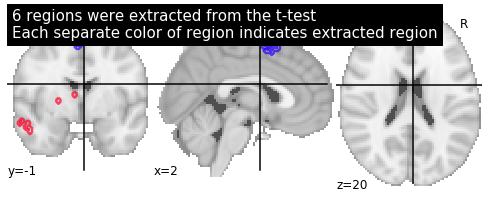

In [133]:
# Visualization of region extraction results
title = ('%d regions were extracted from the t-test'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

In [129]:
print(regions_extracted_img.shape)
single_mni_image = index_img(regions_extracted_img, 0)
print(single_mni_image.shape)
type(single_mni_image)
single_mni_image.ImageArrayProxy

(97, 115, 97, 6)
(97, 115, 97)


nibabel.arrayproxy.ArrayProxy

In [130]:
num_regions=regions_extracted_img.shape[-1]
num_regions

6

In [131]:
regions_value_img.shape

(97, 115, 97, 13)

# Generate a results table
Now that we have images of our regions we want to get the center of each activation


In [132]:
num_regions=regions_extracted_img.shape[-1]

print("MNI Coordinates ")
print("X, Y, Z, NumVox, PeakTValue")
for i in range(num_regions):
    single_mni_image = index_img(regions_extracted_img, i)
    xyztemp=find_xyz_cut_coords(single_mni_image, activation_threshold=threshold)
    xyz = [ '%.0f' % elem for elem in xyztemp ]
    numvox=len(numpy.where(single_mni_image.dataobj>0)[0])
    maxval=single_mni_image.dataobj.max()
    xyz = [*xyz, str(numvox),str(maxval)]
    print(*xyz, sep=", ")

MNI Coordinates 
X, Y, Z, NumVox, PeakTValue
33, -62, -30, 513, 11.720063
-48, 31, -8, 129, 6.5949087
-17, -90, -12, 105, 5.813235
-19, 38, 50, 234, 8.79869
-0, 8, 57, 278, 9.300496
15, -94, -2, 170, 7.6724486


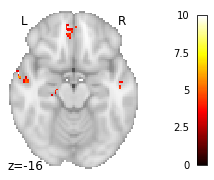

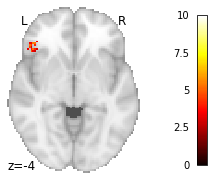

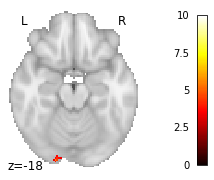

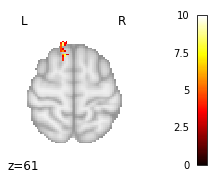

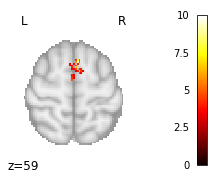

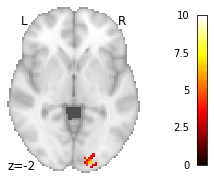

In [140]:
#Set vmax to the peak t value observed above
vmax=10
for img in image.iter_img(regions_extracted_img):
    # img is now an in-memory 3D img
    plotting.plot_stat_map(img, display_mode="z", cut_coords=1,
                           colorbar=True,vmax=vmax)

In [ ]:
#Now select a display_mode to view your ROIs differently

for img in image.iter_img(regions_extracted_img):
    # img is now an in-memory 3D img
    plotting.plot_stat_map(img, display_mode="z", cut_coords=1,
                           colorbar=True,vmax=vmax)